# Transfer Learning LaneNet

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [3]:
# !pip install glog

### Modules

In [4]:
import argparse
import math
import os
import os.path as ops
import time

import cv2
import glog as log
import numpy as np

from easydict import EasyDict as edict
from collections import OrderedDict
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf

In [6]:
print(tf.__version__)

In [7]:
from google.colab import drive
drive.mount('drive')
os.chdir('drive/MyDrive/Lane_Detection')

In [8]:
# Disable Eager Execution
tf.compat.v1.disable_eager_execution()

In [9]:
# ignore warning for tf 2.0
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Setting Data Set and Weights Path

In [10]:
dataset_dir = 'ComputerVision/workspace/images/100k_train/'

In [11]:
weights_path = None

## Setting Model Paths

In [12]:
model_save_dir_m   = 'lanenet'
model_name_m       = 'lanenet'
name_m             = 'lanenet'
tboard_save_path_m = 'lanenet'
image_save_path_m  = 'lanenet'

## Setting parameters

In [13]:
__C = edict()

cfg = __C

__C.TRAIN = edict()

__C.TRAIN.EPOCHS = 250
__C.TRAIN.NOOFBATCHES = 20
__C.TRAIN.BATCH_SIZE = 10

__C.TRAIN.MOMENTUM = 0.9
__C.TRAIN.LEARNING_RATE = 0.0005
__C.TRAIN.GPU_MEMORY_FRACTION = 0.85
__C.TRAIN.TF_ALLOW_GROWTH = True
__C.TRAIN.IMG_HEIGHT = 256
__C.TRAIN.IMG_WIDTH = 512

## Reading Data Set

In [14]:
class DataSet(object):
    def __init__(self, dataset_info_file):
        self._gt_img_list, self._gt_label_binary_list = self._init_dataset(dataset_info_file)
        self._random_dataset()
        self._next_batch_loop_count = 0

    def _init_dataset(self, dataset_info_file):
        gt_img_list = []
        gt_label_binary_list = []

        assert ops.exists(dataset_info_file), '{:s} does not exist'.format(dataset_info_file)

        with open(dataset_info_file, 'r') as file:
            for _info in file:
                info_tmp = _info.strip(' ').split()

                gt_img_list.append(info_tmp[0])
                gt_label_binary_list.append(info_tmp[1])

        return gt_img_list, gt_label_binary_list

    def _random_dataset(self):
        assert len(self._gt_img_list) == len(self._gt_label_binary_list)

        random_idx = np.random.permutation(len(self._gt_img_list))
        new_gt_img_list = []
        new_gt_label_binary_list = []

        for index in random_idx:
            new_gt_img_list.append(self._gt_img_list[index])
            new_gt_label_binary_list.append(self._gt_label_binary_list[index])

        self._gt_img_list = new_gt_img_list
        self._gt_label_binary_list = new_gt_label_binary_list

    def next_batch(self, batch_size):
        assert len(self._gt_label_binary_list) == len(self._gt_img_list)

        idx_start = batch_size * self._next_batch_loop_count
        idx_end = batch_size * self._next_batch_loop_count + batch_size

        if idx_start == 0 and idx_end > len(self._gt_label_binary_list):
            raise ValueError('Batch size cannot be larger than the total number of samples', 
                             idx_end, len(self._gt_label_binary_list))

        if idx_end > len(self._gt_label_binary_list):
            self._random_dataset()
            self._next_batch_loop_count = 0
            return self.next_batch(batch_size)
        else:
            gt_img_list = self._gt_img_list[idx_start:idx_end]
            gt_label_binary_list = self._gt_label_binary_list[idx_start:idx_end]

            gt_imgs = []
            gt_labels_binary = []

            for gt_img_path in gt_img_list:
                gt_imgs.append(cv2.imread(gt_img_path, cv2.IMREAD_COLOR))

            for gt_label_path in gt_label_binary_list:
                label_img = cv2.imread(gt_label_path, cv2.IMREAD_COLOR)
                label_binary = np.zeros([label_img.shape[0], label_img.shape[1]], dtype=np.uint8)
                idx = np.where((label_img[:, :, :] != [0, 0, 0]).all(axis=2))
                label_binary[idx] = 1
                gt_labels_binary.append(label_binary)

            self._next_batch_loop_count += 1

        return gt_imgs, gt_labels_binary

In [15]:
# train dataset
train_dataset_file = ops.join(dataset_dir, 'train.txt')
assert ops.exists(train_dataset_file)
train_dataset = DataSet(train_dataset_file)

## CNN Base Function
### cnn_basenet.py

In [16]:
class CNNBaseModel(object):
    def __init__(self):
        pass

    @staticmethod
    def conv2d(inputdata, out_channel, kernel_size, padding='SAME',
               stride=1, w_init=None, b_init=None,
               split=1, use_bias=True, data_format='NHWC', name=None):
        with tf.compat.v1.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'NHWC' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Conv2D] Input cannot have unknown channel!"
            assert in_channel % split == 0
            assert out_channel % split == 0

            padding = padding.upper()

            if isinstance(kernel_size, list):
                filter_shape = [kernel_size[0], kernel_size[1]] + [int(in_channel / split), out_channel]
            else:
                filter_shape = [kernel_size, kernel_size] + [int(in_channel / split), out_channel]

            if isinstance(stride, list):
                strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                    else [1, 1, stride[0], stride[1]]
            else:
                strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                    else [1, 1, stride, stride]

            if w_init is None:
                w_init = tf.initializers.variance_scaling()
            if b_init is None:
                b_init = tf.constant_initializer()

            w = tf.compat.v1.get_variable('W', filter_shape, initializer=w_init)
            b = None

            if use_bias:
                b = tf.compat.v1.get_variable('b', [out_channel], initializer=b_init)

            if split == 1:
                conv = tf.nn.conv2d(inputdata, w, strides, padding, data_format=data_format)
            else:
                inputs = tf.split(inputdata, split, channel_axis)
                kernels = tf.split(w, split, 3)
                outputs = [tf.nn.conv2d(i, k, strides, padding, data_format=data_format)
                           for i, k in zip(inputs, kernels)]
                conv = tf.concat(outputs, channel_axis)

            ret = tf.identity(tf.nn.bias_add(conv, b, data_format=data_format) if use_bias else conv, name=name)

        return ret

    @staticmethod
    def relu(inputdata, name=None):
        return tf.nn.relu(features=inputdata, name=name)

    @staticmethod
    def maxpooling(inputdata, kernel_size, stride=None, \
                   padding='VALID', data_format='NHWC', name=None):
        padding = padding.upper()

        if stride is None:
            stride = kernel_size

        if isinstance(kernel_size, list):
            kernel = [1, kernel_size[0], kernel_size[1], 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size[0], kernel_size[1]]
        else:
            kernel = [1, kernel_size, kernel_size, 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size, kernel_size]

        if isinstance(stride, list):
            strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                else [1, 1, stride[0], stride[1]]
        else:
            strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                else [1, 1, stride, stride]

        return tf.nn.max_pool(input=inputdata, ksize=kernel, strides=strides, \
                              padding=padding, data_format=data_format, name=name)

    @staticmethod
    def layerbn(inputdata, is_training, name):
        return tf.compat.v1.layers.batch_normalization(inputs=inputdata, training=is_training, name=name)

    @staticmethod
    def deconv2d(inputdata, out_channel, kernel_size, padding='SAME',
                 stride=1, w_init=None, b_init=None,
                 use_bias=True, activation=None, data_format='channels_last',
                 trainable=True, name=None):
        with tf.compat.v1.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'channels_last' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Deconv2D] Input cannot have unknown channel!"

            padding = padding.upper()

            if w_init is None:
                w_init = tf.initializers.variance_scaling()
            if b_init is None:
                b_init = tf.constant_initializer()

            ret = tf.compat.v1.layers.conv2d_transpose(inputs=inputdata, filters=out_channel,
                                             kernel_size=kernel_size,
                                             strides=stride, padding=padding,
                                             data_format=data_format,
                                             activation=activation, use_bias=use_bias,
                                             kernel_initializer=w_init,
                                             bias_initializer=b_init, trainable=trainable,
                                             name=name)
        return ret

## Defining model using conv2d, Relu and Maxpooling
## fcn_decoder.py

In [17]:
class FCNDecoder(CNNBaseModel):
    def __init__(self, phase):
        super(FCNDecoder, self).__init__()

    def decode(self, input_tensor_dict, decode_layer_list, name):
        ret = dict()

        with tf.compat.v1.variable_scope(name):
            # score stage 1
            input_tensor = input_tensor_dict[decode_layer_list[0]]['data']

            score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                kernel_size=1, use_bias=False, name='score_origin')
            decode_layer_list = decode_layer_list[1:]
            for i in range(len(decode_layer_list)):
                deconv = self.deconv2d(inputdata=score, out_channel=64, kernel_size=4,
                                       stride=2, use_bias=False, name='deconv_{:d}'.format(i + 1))
                input_tensor = input_tensor_dict[decode_layer_list[i]]['data']
                score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                    kernel_size=1, use_bias=False, name='score_{:d}'.format(i + 1))
                fused = tf.add(deconv, score, name='fuse_{:d}'.format(i + 1))
                score = fused

            deconv_final = self.deconv2d(inputdata=score, out_channel=64, kernel_size=16,
                                         stride=8, use_bias=False, name='deconv_final')

            score_final = self.conv2d(inputdata=deconv_final, out_channel=2,
                                      kernel_size=1, use_bias=False, name='score_final')

            ret['logits'] = score_final

        return ret

## vgg_encoder.py
https://github.com/machrisaa/tensorflow-vgg

In [18]:
class VGG16Encoder(CNNBaseModel):
    def __init__(self, phase):
        super(VGG16Encoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def _conv_stage(self, input_tensor, k_size, out_dims, name,
                    stride=1, pad='SAME'):
        with tf.compat.v1.variable_scope(name):
            conv = self.conv2d(inputdata=input_tensor, out_channel=out_dims,
                               kernel_size=k_size, stride=stride,
                               use_bias=False, padding=pad, name='conv')

            bn = self.layerbn(inputdata=conv, is_training=self._is_training, name='bn')

            relu = self.relu(inputdata=bn, name='relu')

            return relu

    def encode(self, input_tensor, name):
        ret = OrderedDict()

        with tf.compat.v1.variable_scope(name):
            # conv stage 1
            conv_1_1 = self._conv_stage(input_tensor=input_tensor, k_size=3, out_dims=64, name='conv1_1')
            conv_1_2 = self._conv_stage(input_tensor=conv_1_1, k_size=3, out_dims=64, name='conv1_2')
            pool1 = self.maxpooling(inputdata=conv_1_2, kernel_size=2, stride=2, name='pool1')

            # conv stage 2
            conv_2_1 = self._conv_stage(input_tensor=pool1, k_size=3, out_dims=128, name='conv2_1')
            conv_2_2 = self._conv_stage(input_tensor=conv_2_1, k_size=3, out_dims=128, name='conv2_2')
            pool2 = self.maxpooling(inputdata=conv_2_2, kernel_size=2, stride=2, name='pool2')

            # conv stage 3
            conv_3_1 = self._conv_stage(input_tensor=pool2, k_size=3, out_dims=256, name='conv3_1')
            conv_3_2 = self._conv_stage(input_tensor=conv_3_1, k_size=3, out_dims=256, name='conv3_2')
            conv_3_3 = self._conv_stage(input_tensor=conv_3_2, k_size=3, out_dims=256, name='conv3_3')
            pool3 = self.maxpooling(inputdata=conv_3_3, kernel_size=2, stride=2, name='pool3')
            ret['pool3'] = dict()
            ret['pool3']['data'] = pool3
            ret['pool3']['shape'] = pool3.get_shape().as_list()

            # conv stage 4
            conv_4_1 = self._conv_stage(input_tensor=pool3, k_size=3, out_dims=512, name='conv4_1')
            conv_4_2 = self._conv_stage(input_tensor=conv_4_1, k_size=3, out_dims=512, name='conv4_2')
            conv_4_3 = self._conv_stage(input_tensor=conv_4_2, k_size=3, out_dims=512, name='conv4_3')
            pool4 = self.maxpooling(inputdata=conv_4_3, kernel_size=2, stride=2, name='pool4')
            ret['pool4'] = dict()
            ret['pool4']['data'] = pool4
            ret['pool4']['shape'] = pool4.get_shape().as_list()

            # conv stage 5
            conv_5_1 = self._conv_stage(input_tensor=pool4, k_size=3, out_dims=512, name='conv5_1')
            conv_5_2 = self._conv_stage(input_tensor=conv_5_1, k_size=3, out_dims=512, name='conv5_2')
            conv_5_3 = self._conv_stage(input_tensor=conv_5_2, k_size=3, out_dims=512, name='conv5_3')
            pool5 = self.maxpooling(inputdata=conv_5_3, kernel_size=2, stride=2, name='pool5')
            ret['pool5'] = dict()
            ret['pool5']['data'] = pool5
            ret['pool5']['shape'] = pool5.get_shape().as_list()

        return ret

## lanenet_merge_model.py

In [19]:
class LaneNet():
    def __init__(self, phase):
        super(LaneNet, self).__init__()
        self._encoder = VGG16Encoder(phase=phase)
        self._decoder = FCNDecoder(phase=phase)
        return

    def _build_model(self, input_tensor, name):
        with tf.compat.v1.variable_scope(name):
            # first encode
            encode_ret = self._encoder.encode(input_tensor=input_tensor,
                                              name='encode')
            # second decode
            decode_ret = self._decoder.decode(input_tensor_dict=encode_ret,
                                              name='decode',
                                              decode_layer_list=['pool5',
                                                                 'pool4',
                                                                 'pool3'])
            return decode_ret

    def compute_loss(self, input_tensor, binary_label, name):
        with tf.compat.v1.variable_scope(name):
            # Forward propagation to get logits
            inference_ret = self._build_model(input_tensor=input_tensor, name='inference')

            # Calculate the binary partition loss function
            decode_logits = inference_ret['logits']
            binary_label_plain = tf.reshape(binary_label,
                                            shape=[binary_label.get_shape().as_list()[0] *
                                                   binary_label.get_shape().as_list()[1] *
                                                   binary_label.get_shape().as_list()[2]])
            # Add class weights
            unique_labels, unique_id, counts = tf.unique_with_counts(binary_label_plain)
            counts = tf.cast(counts, tf.dtypes.float32)
            inverse_weights = tf.divide(1.0,
                                        tf.math.log(tf.add(tf.divide(tf.constant(1.0), counts),
                                                      tf.constant(1.02))))
            inverse_weights = tf.gather(inverse_weights, binary_label)
            binary_segmentation_loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=binary_label, \
                                                                               logits=decode_logits, \
                                                                               weights=inverse_weights)
            binary_segmentation_loss = tf.reduce_mean(binary_segmentation_loss)

            ret = {'loss': binary_segmentation_loss, 'binary_seg_logits': decode_logits}

            return ret

## Define cost, optimizer and accuracy

In [20]:
CFG = cfg

In [21]:
with tf.device('/gpu:0'):
    input_tensor = tf.compat.v1.placeholder(dtype=tf.float32,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 3],
                                  name='input_tensor')
    binary_label = tf.compat.v1.placeholder(dtype=tf.int64,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 1],
                                         name='binary_label')

    # Create the model
    phase = tf.compat.v1.placeholder(dtype=tf.string, shape=None, name='net_phase')
    net = LaneNet(phase=phase)

    # Define loss
    compute_ret = net.compute_loss(input_tensor=input_tensor, binary_label=binary_label, name='lanenet_model')
    loss = compute_ret['loss']

    # Evaluate model
    out_logits = compute_ret['binary_seg_logits']
    out_logits = tf.nn.softmax(logits=out_logits)
    out_logits_out = tf.argmax(out_logits, axis=-1)
    out = tf.argmax(out_logits, axis=-1)
    out = tf.expand_dims(out, axis=-1)

    idx = tf.where(tf.equal(binary_label, 1))
    pix_cls_ret = tf.gather_nd(out, idx)
    accuracy = tf.compat.v1.count_nonzero(pix_cls_ret)
    accuracy = tf.divide(accuracy, tf.cast(tf.shape(pix_cls_ret)[0], tf.int64))

    # Define optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.compat.v1.train.exponential_decay(CFG.TRAIN.LEARNING_RATE, global_step,
                                               100000, 0.1, staircase=True)
    update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=learning_rate, \
                                               momentum=CFG.TRAIN.MOMENTUM).minimize(loss=loss,
                                                                                     var_list=tf.compat.v1.trainable_variables(),
                                                                                     global_step=global_step)

## Set a session

In [22]:
# Set sess configuration
sess_config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
sess_config.gpu_options.allocator_type = 'BFC'

sess = tf.compat.v1.Session(config=sess_config)

In [23]:
# Set tf saver
model_save_dir = 'ComputerVision/workspace/models/{}'.format(model_save_dir_m)
if not ops.exists(model_save_dir):
    os.makedirs(model_save_dir)

train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
model_name = '{}_{:s}.ckpt'.format(model_name_m,str(train_start_time))
model_save_path = ops.join(model_save_dir, model_name)

saver = tf.compat.v1.train.Saver()

tf.compat.v1.train.write_graph(graph_or_graph_def=sess.graph, logdir='',
                     name='{:s}/{}_model.pb'.format(model_save_dir,name_m))

In [24]:
# Set tf summary
tboard_save_path = 'ComputerVision/workspace/models/tboard/{}_{:s}'.format(tboard_save_path_m,str(train_start_time))
if not ops.exists(tboard_save_path):
    os.makedirs(tboard_save_path)

train_accuracy_scalar = tf.compat.v1.summary.scalar(name='train_accuracy', tensor=accuracy)
train_loss_scalar = tf.compat.v1.summary.scalar(name='train_loss', tensor=loss)
learning_rate_scalar = tf.compat.v1.summary.scalar(name='learning_rate', tensor=learning_rate)
merged_summary_op = tf.compat.v1.summary.merge([train_accuracy_scalar, train_loss_scalar, learning_rate_scalar])

summary_writer = tf.compat.v1.summary.FileWriter(tboard_save_path)
summary_writer.add_graph(sess.graph)

In [25]:
# Set output image folder
image_save_path = 'ComputerVision/workspace/data_ret/{}_{:s}'.format(image_save_path_m,str(train_start_time))
if not ops.exists(image_save_path):
    os.makedirs(image_save_path)

## Running the session

In [26]:
VGG_MEAN = [103.939, 116.779, 123.68]

history = []
train_cost_time_mean = []

In [27]:
def resize_training_data(gt_imgs, binary_gt_labels):
    gt_imgs = [cv2.resize(tmp,
                          dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                          dst=tmp,
                          interpolation=cv2.INTER_LINEAR)
               for tmp in gt_imgs]
    gt_imgs = [tmp - VGG_MEAN for tmp in gt_imgs]

    binary_gt_labels = [cv2.resize(tmp,
                                   dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                                   dst=tmp,
                                   interpolation=cv2.INTER_NEAREST)
                        for tmp in binary_gt_labels]
    binary_gt_labels = [np.expand_dims(tmp, axis=-1) for tmp in binary_gt_labels]
    
    return gt_imgs, binary_gt_labels

## Running Session

In [28]:
with sess.as_default():
    # sess init or restore
    if weights_path is None:
        log.info('Training from scratch')
        init = tf.compat.v1.global_variables_initializer()
        sess.run(init)

        # read vgg model
        pretrained_weights = np.load('./ComputerVision/workspace/models/vgg16/vgg16.npy', encoding='latin1').item()
        for vv in tf.compat.v1.trainable_variables():
            weights_key = vv.name.split('/')[-3]
            try:
                weights = pretrained_weights[weights_key][0]
                _op = tf.assign(vv, weights)
                sess.run(_op)
            except Exception as e:
                continue
    else:
        init = tf.compat.v1.global_variables_initializer()
        sess.run(init)
        log.info('Restore model from last model checkpoint {:s}'.format(weights_path))
        # restore weights
        saver.restore(sess=sess, save_path=weights_path)

    
    # epoch loop
    for epoch in range(CFG.TRAIN.EPOCHS):
        t0 = time.time()
        # Use training data for optimization
        for _ in range(CFG.TRAIN.NOOFBATCHES):
            with tf.device('/gpu:0'):
                gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
                gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

            sess.run(optimizer, feed_dict={input_tensor:gt_imgs, 
                                           binary_label:binary_gt_labels, 
                                           phase:'train'})


        # Validate after every epoch
        t_start = time.time()
        with tf.device('/gpu:0'):
            gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
            gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

        train_loss, train_accuracy, train_img, train_summary = \
            sess.run([loss, accuracy, out_logits_out, merged_summary_op],
                     feed_dict={input_tensor: gt_imgs,
                                binary_label: binary_gt_labels,
                                phase: 'train'})

        # time
        cost_time = time.time() - t_start
        train_cost_time_mean.append(cost_time)
        
        # summary
        summary_writer.add_summary(summary=train_summary, global_step=epoch)

        # history
        if (epoch+1)*CFG.TRAIN.NOOFBATCHES > 0:  ## ## =========================> CHANGE!!
            history.append([train_loss, train_accuracy])

        # progress
        if (epoch+1)*CFG.TRAIN.NOOFBATCHES % 1 == 0:  ## ## =========================> CHANGE!!
            print('Epoch: {:6d} loss= {:6f} acc= {:6f} cost_time= {:5f}s - Time={:.2f} min'.
                  format(epoch+1, train_loss, train_accuracy, np.mean(train_cost_time_mean), (time.time()-t0)/60))
            train_cost_time_mean.clear()

        # output image
        if (epoch+1) % 10 == 0:  ## ## =========================> CHANGE!!
            binary_seg_image_3ch = np.array([[[0]*3]*__C.TRAIN.IMG_WIDTH]*__C.TRAIN.IMG_HEIGHT, np.float64)
            binary_seg_image_3ch[:, :, 0] = 0
            binary_seg_image_3ch[:, :, 1] = 0
            binary_seg_image_3ch[:, :, 2] = train_img[0][:, :]*255
            image = gt_imgs[0] + VGG_MEAN
            image_field2 = cv2.addWeighted(image, 1.0, binary_seg_image_3ch, 1.0, 0.0)
            path = image_save_path + '/image_{:d}.png'.format(epoch)
            cv2.imwrite(path, image_field2)

        # store model
        if (epoch+1) % 10 == 0: ## ## =========================> CHANGE!!
            saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

# store model
saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

sess.close()


INFO:root:Training from Scratch
Epoch:      1 loss= 8.407863 acc= 0.000000 cost_time= 10.423600s - Time=2.80 min
Epoch:      2 loss= 5.295705 acc= 0.000133 cost_time= 8.774320s - Time=3.30 min
Epoch:      3 loss= 4.617456 acc= 0.000466 cost_time= 11.452680s - Time=3.20 min
Epoch:      4 loss= 4.118353 acc= 0.011168 cost_time= 8.338480s - Time=2.72 min
Epoch:      5 loss= 4.329785 acc= 0.089794 cost_time= 9.836720s - Time=2.90 min
Epoch:      6 loss= 4.414037 acc= 0.023806 cost_time= 8.298720s - Time=3.32 min
Epoch:      7 loss= 4.172986 acc= 0.167781 cost_time= 11.533240s - Time=2.95 min
Epoch:      8 loss= 4.715472 acc= 0.022435 cost_time= 10.935520s - Time=3.20 min
Epoch:      9 loss= 4.285030 acc= 0.068890 cost_time= 9.130720s - Time=3.50 min
Epoch:     10 loss= 4.740760 acc= 0.047495 cost_time= 9.390120s - Time=2.87 min
Epoch:     11 loss= 4.707498 acc= 0.052640 cost_time= 10.287320s - Time=2.65 min
Epoch:     12 loss= 5.455675 acc= 0.044456 cost_time= 10.132080s - Time=3.25 min
Ep

In [29]:
# History array
history = np.array(history)

# Saving
np.save('{}/history_{}.npy'.format(model_save_dir, train_start_time), history)

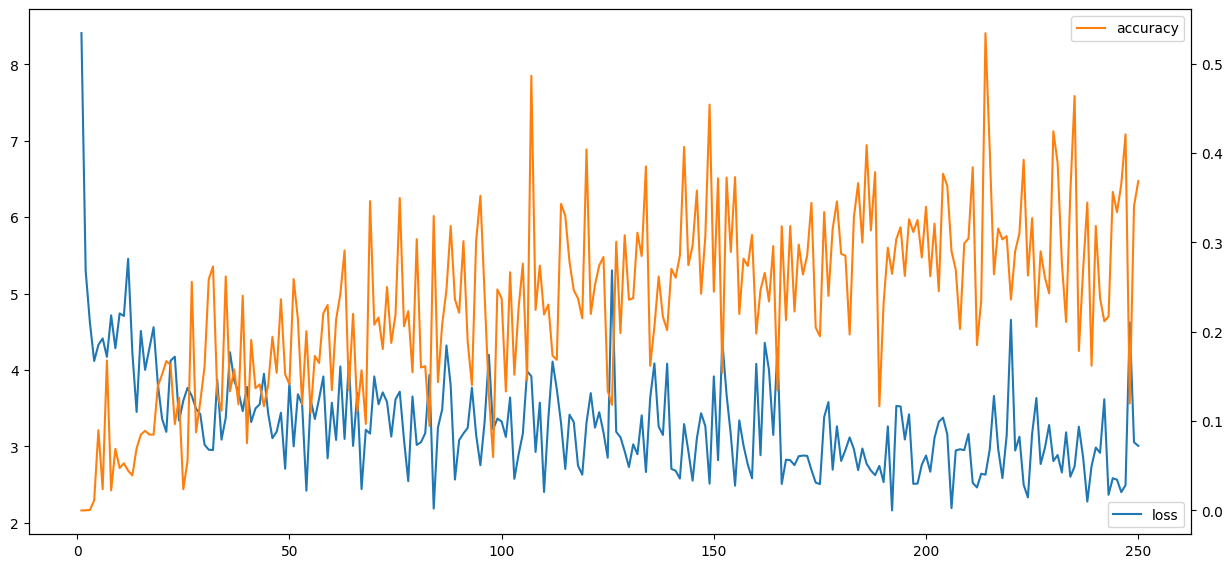

In [30]:
cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(15,15),dpi=100)
ax1 = fig.add_subplot(2,1,1, facecolor='w')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 0], label='loss')
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 1], label='accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()

In [31]:
# Moving Average (history)
import pandas as pd
history_ma = history.copy()
history_ma[:,0] = pd.Series(history[:,0]).rolling(window=10, min_periods=1).mean().values
history_ma[:,1] = pd.Series(history[:,1]).rolling(window=10, min_periods=1).mean().values

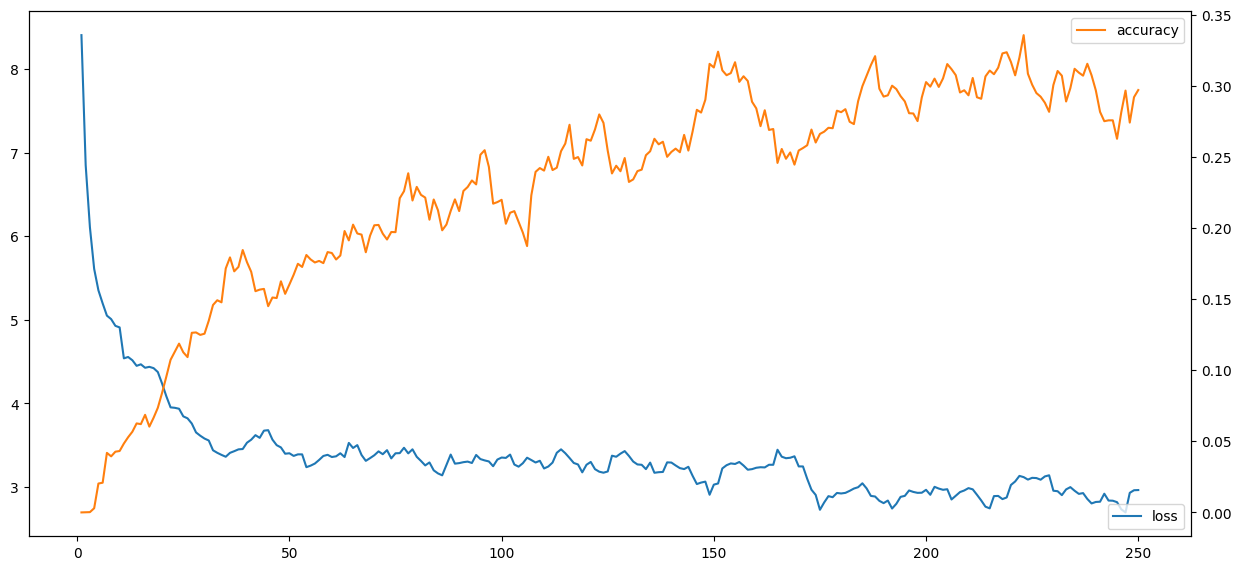

In [32]:
cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(15,15),dpi=100)
ax1 = fig.add_subplot(2,1,1, facecolor='w')
ax1.plot(np.arange(1, history_ma.shape[0] + 1), history_ma[:, 0], label='loss')
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history_ma.shape[0] + 1), history_ma[:, 1], label='accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()